<a href="https://colab.research.google.com/github/Real1CM/MLassignment/blob/main/%E4%BD%9C%E4%B8%9A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

任务一

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset,DataLoader
import numpy as np
import struct
from PIL import Image

In [2]:
class MnistDataset(Dataset):
    def __init__(self,mnist_idx_path,opt):
        code2type = {0x08: 'B', 0x09: 'b', 0x0B: 'h', 0x0c: 'i', 0x0D: 'f', 0x0E: 'd'}
        self.transform = transforms.Compose([
                                     transforms.Resize(opt.imageSize),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,)),
                                 ])
        with open(mnist_idx_path, 'rb') as f:
            buff = f.read()
            offset = 0
            fmt = '>HBB'  # 格式定义，>表示高位在前，I表示4字节整数
            _, dcode, dimslen = struct.unpack_from(fmt, buff, offset)
            offset += struct.calcsize(fmt)

            fmt = '>{}I'.format(dimslen)
            shapes = struct.unpack_from(fmt, buff, offset)
            offset += struct.calcsize(fmt)

            fmt = '>' + str(np.prod(shapes)) + code2type[dcode]
            matrix = struct.unpack_from(fmt, buff, offset)
            self.images = np.reshape(matrix, shapes).astype(code2type[dcode])
            self.len = shapes[0]

    def __getitem__(self, index):
        img = self.images[index,...]
        img = Image.fromarray(img, mode="L")
        img = self.transform(img)
        return img

    def __len__(self):
        return self.len


In [12]:
class Opt:
    dataroot='./'
    batchSize=16
    imageSize=64
    nz=10 #size of the latent z vector
    nc=1
    ngf=32 #netG channels
    ndf=32
    epochs=500 #'number of epochs to train for'
    lr=0.0002
    beta1=0.5
    netG=''#./netG.pth'
    netD=''#./netD.pth'
    outf='./'
    manualSeed = 1000

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [14]:
class Generator(nn.Module):
    def __init__(self,nz,nc,ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [15]:
class Discriminator(nn.Module):
    def __init__(self,nc,ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [18]:
def train():
    opt = Opt()

    if opt.manualSeed is None:
        opt.manualSeed = random.randint(1, 10000)
    print("Random Seed: ", opt.manualSeed)
    random.seed(opt.manualSeed)
    torch.manual_seed(opt.manualSeed)

    dataset = MnistDataset('./t10k-images-idx3-ubyte',opt)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                             shuffle=True, num_workers=0)

    netG = Generator(opt.nz, opt.nc, opt.ngf)
    netG.apply(weights_init)
    if opt.netG != '':
        netG.load_state_dict(torch.load(opt.netG))
    # print(netG)

    netD = Discriminator(opt.nc, opt.ndf)
    netD.apply(weights_init)
    if opt.netD != '':
        netD.load_state_dict(torch.load(opt.netD))
    # print(netD)

    criterion = nn.BCELoss()

    fixed_noise = torch.randn(opt.batchSize, opt.nz, 1, 1)
    real_label = 1
    fake_label = 0

    # setup optimizer
    optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

    for epoch in range(opt.epochs):
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label,
                               dtype=real_cpu.dtype)

            output = netD(real_cpu)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, opt.nz, 1, 1)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' %
      (epoch, opt.epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            if i % 100 == 0:
                vutils.save_image(real_cpu,
                                  '%s/real_samples.png' % opt.outf,
                                  normalize=True)
                fake = netG(fixed_noise)
                vutils.save_image(fake.detach(),
                                  '%s/fake_samples_epoch_%03d.png' %
                                 (opt.outf, epoch),
                                  normalize=True)
        # do checkpointing
        torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
        torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

if __name__ == '__main__':
    train()

Random Seed:  1000
[0/500][0/625] Loss_D: 1.7040 Loss_G: 2.3435 D(x): 0.7328 D(G(z)): 0.7092 / 0.1342
[0/500][1/625] Loss_D: 1.1078 Loss_G: 2.7100 D(x): 0.8810 D(G(z)): 0.6052 / 0.1048
[0/500][2/625] Loss_D: 0.7086 Loss_G: 2.9941 D(x): 0.9079 D(G(z)): 0.4117 / 0.0980
[0/500][3/625] Loss_D: 0.4218 Loss_G: 3.3534 D(x): 0.9573 D(G(z)): 0.2987 / 0.0454
[0/500][4/625] Loss_D: 0.3911 Loss_G: 3.2711 D(x): 0.9391 D(G(z)): 0.2612 / 0.0552
[0/500][5/625] Loss_D: 0.3618 Loss_G: 3.3519 D(x): 0.9383 D(G(z)): 0.2398 / 0.0471
[0/500][6/625] Loss_D: 0.3717 Loss_G: 3.3589 D(x): 0.9557 D(G(z)): 0.2717 / 0.0450
[0/500][7/625] Loss_D: 0.2760 Loss_G: 3.4603 D(x): 0.9581 D(G(z)): 0.2040 / 0.0401
[0/500][8/625] Loss_D: 0.4045 Loss_G: 3.5928 D(x): 0.9459 D(G(z)): 0.2646 / 0.0440
[0/500][9/625] Loss_D: 0.2720 Loss_G: 3.7767 D(x): 0.9298 D(G(z)): 0.1683 / 0.0307
[0/500][10/625] Loss_D: 0.2820 Loss_G: 3.6463 D(x): 0.9120 D(G(z)): 0.1528 / 0.0325
[0/500][11/625] Loss_D: 0.2860 Loss_G: 3.7402 D(x): 0.9323 D(G(z)):

KeyboardInterrupt: 

这是跑出来的效果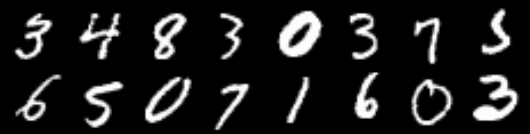

任务二

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

# 1. 加载CIFAR-10数据集
(x_train, _), (_, _) = cifar10.load_data()
x_train = x_train / 127.5 - 1.0  # 归一化到[-1, 1]范围
x_train = x_train.astype("float32")

# 2. 定义生成器模型
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), padding="same", activation="tanh"))
    return model

# 3. 定义判别器模型
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same", input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# 4. 创建生成器和判别器实例
generator = build_generator()
discriminator = build_discriminator()

# 5. 定义损失函数和优化器
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 6. 定义训练过程
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# 7. 设置训练循环
import time
import matplotlib.pyplot as plt

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 每隔一定周期显示生成的图片
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Time: {time.time() - start}')

# 8. 数据集准备与模型训练
buffer_size = 50000
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

epochs = 100
train(train_dataset, epochs)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 